# DEEP LAYERS 2025
## Image Segmentation

**Content:**<br>
1. Data Generator<br>
2. Model Definition<br>
3. Training Procedure<br>
4. Evaluate Model on a New Data<br>

**Author:**<br>
Filip Lux, 2025<br><br>


In [1]:
# Reload the module to get latest changes
%load_ext autoreload
%autoreload 2

# custom tools
from dl_tools import set_device

# environment settings
%matplotlib inline
device = set_device()

=== PyTorch GPU Configuration ===
PyTorch version: 2.9.0+cu128
CUDA available: True
CUDA version: 12.8
cuDNN version: 91002
Number of GPUs: 1
GPU 0: NVIDIA RTX 2000 Ada Generation Laptop GPU
  Memory: 8.0 GB
Using device: cuda:0


## 1. Data Generators

In [19]:

from torch.utils.data import DataLoader
from dl_tools import SegmentationDataset
from torchvision import transforms

# data loader configuration
config_dataset = {"batch_size": 2,
                  "num_workers": 0}

# Augmentation
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=180, fill=0)
])

# train data generators
train_dataset = SegmentationDataset('BF-C2DL-HSC/train', 'BF-C2DL-HSC/train_GT', transform=augment_transform)
train_loader = DataLoader(train_dataset, shuffle=True, **config_dataset)

# validation data generators
val_dataset = SegmentationDataset('BF-C2DL-HSC/validation', 'BF-C2DL-HSC/validation_GT', transform=augment_transform)
val_loader = DataLoader(val_dataset, shuffle=False, **config_dataset)

In [22]:
# get one batch
for im, gt in train_loader:
    break

# show shape
print(im.shape, gt.shape)

torch.Size([2, 1, 1000, 1000]) torch.Size([2, 1, 1000, 1000])


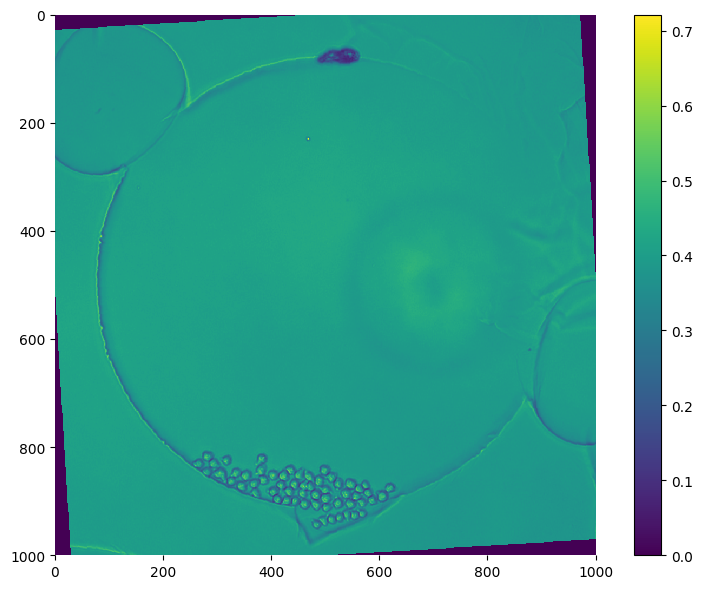

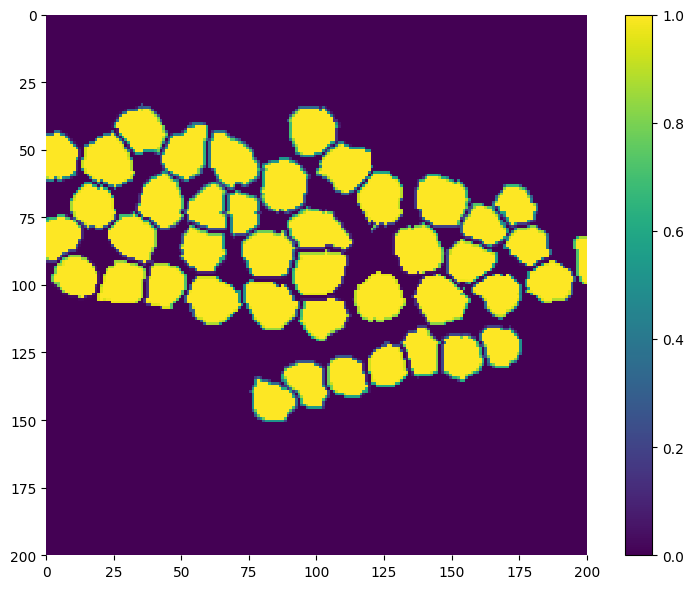

In [25]:
from dl_tools import ishow

# show image
ishow(im[0, 0, :, :])
ishow(gt[0, 0, 800:1000, 400:600])

In [26]:
import torch

# Create final data loaders with preprocessing
class PreprocessedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, no_masks=False):
        self.base_dataset = base_dataset
        self.no_masks = no_masks

    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        if self.no_masks:
            img = self.base_dataset[idx]
            img = self._preprocess_img(img)
            return img
        
        img, gt = self.base_dataset[idx]
        gt = self._preprocess_gt(gt)
        img = self._preprocess_img(img)
        return img, gt
    
    def _preprocess_img(self, img):
        # input preprocessing - standardization
        img -= torch.mean(img)
        img /= torch.std(img)

        return img

    def _preprocess_gt(self, gt):
        # gt preprocessing - only values {0, 1}
        gt = (gt > 0.5).float()
        
        return gt

In [27]:
train_dataset_final = PreprocessedDataset(train_dataset)
val_dataset_final = PreprocessedDataset(val_dataset)

train_loader_final = DataLoader(train_dataset_final, shuffle=True, **config_dataset)
val_loader_final = DataLoader(val_dataset_final, shuffle=False, **config_dataset)

In [28]:
# get one batch
for im, gt in val_loader_final:
    break

print(im.shape, gt.shape)

torch.Size([2, 1, 1000, 1000]) torch.Size([2, 1, 1000, 1000])


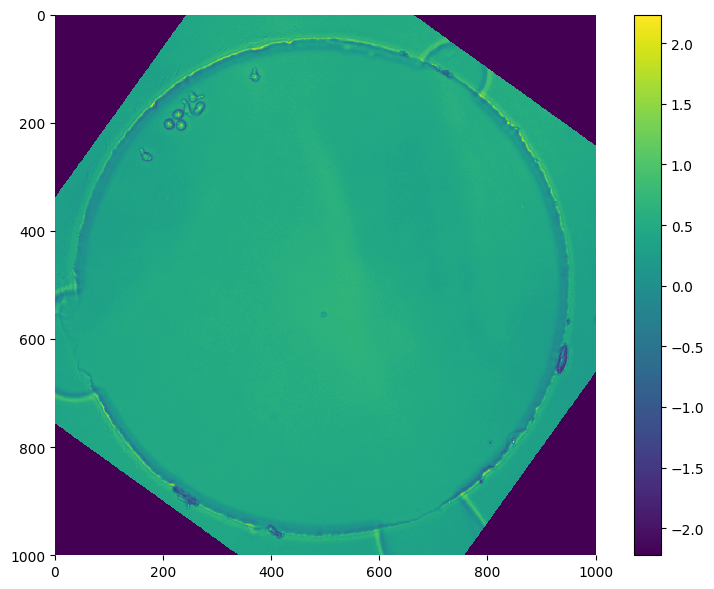

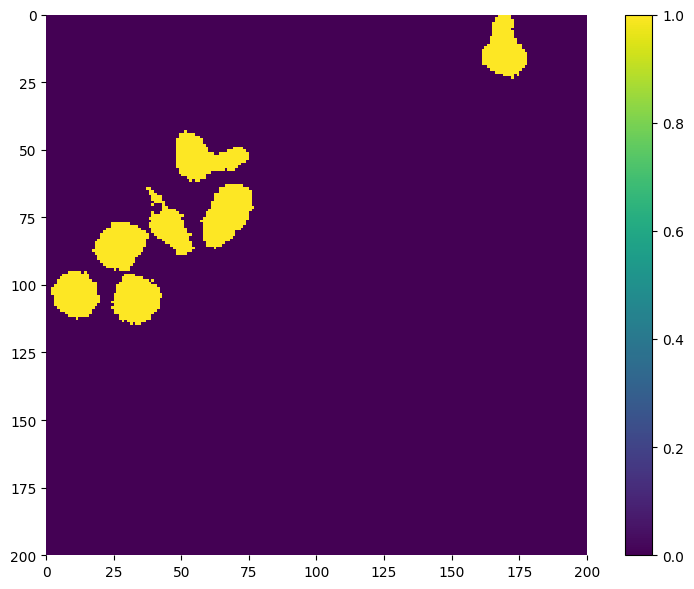

In [30]:
# show image
ishow(im[0, 0, :, :])
ishow(gt[0, 0, 100:300, 200:400])

## 2. Model Definition

In [9]:
from torch import nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(UNet, self).__init__()
        
        # Encoder block 1
        self.conv1_1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.conv1_2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        
        # Encoder block 2
        self.conv2_1 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        
        # Encoder block 3 (bottleneck)
        self.conv3_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3_2 = nn.Conv2d(128, 128, 3, padding=1)
        
        # Decoder block 2
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv4_1 = nn.Conv2d(128 + 64, 64, 3, padding=1)
        self.conv4_2 = nn.Conv2d(64, 64, 3, padding=1)
        
        # Decoder block 1
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv5_1 = nn.Conv2d(64 + 32, 32, 3, padding=1)
        self.conv5_2 = nn.Conv2d(32, 32, 3, padding=1)
        
        # Output layer
        self.final_conv = nn.Conv2d(32, num_classes, 1)
        
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Encoder block 1
        c1_1 = self.relu(self.conv1_1(x))
        c1_2 = self.relu(self.conv1_2(c1_1))
        p1 = self.pool1(c1_2)
        
        # Encoder block 2
        c2_1 = self.relu(self.conv2_1(p1))
        c2_2 = self.relu(self.conv2_2(c2_1))
        p2 = self.pool2(c2_2)
        
        # Encoder block 3
        c3_1 = self.relu(self.conv3_1(p2))
        c3_2 = self.relu(self.conv3_2(c3_1))
        
        # Decoder block 2
        up2 = self.up2(c3_2)
        merge2 = torch.cat([up2, c2_2], dim=1)
        c4_1 = self.relu(self.conv4_1(merge2))
        c4_2 = self.relu(self.conv4_2(c4_1))
        
        # Decoder block 1
        up1 = self.up1(c4_2)
        merge1 = torch.cat([up1, c1_2], dim=1)
        c5_1 = self.relu(self.conv5_1(merge1))
        c5_2 = self.relu(self.conv5_2(c5_1))
        
        # Output
        output = self.final_conv(c5_2)
        
        return output

model = UNet(in_channels=1, num_classes=2)
print(model)

UNet(
  (conv1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up2): Upsample(scale_factor=2.0, mode='bilinear')
  (conv4_1): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up1): Upsample(scale_factor=2.0, mode='bilinear')
  (conv5_1): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [10]:
from torchsummary import summary

# Move model to device and show summary
model = model.to(device)
summary(model, (1, 1000, 1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1000, 1000]             320
              ReLU-2       [-1, 32, 1000, 1000]               0
            Conv2d-3       [-1, 32, 1000, 1000]           9,248
              ReLU-4       [-1, 32, 1000, 1000]               0
         MaxPool2d-5         [-1, 32, 500, 500]               0
            Conv2d-6         [-1, 64, 500, 500]          18,496
              ReLU-7         [-1, 64, 500, 500]               0
            Conv2d-8         [-1, 64, 500, 500]          36,928
              ReLU-9         [-1, 64, 500, 500]               0
        MaxPool2d-10         [-1, 64, 250, 250]               0
           Conv2d-11        [-1, 128, 250, 250]          73,856
             ReLU-12        [-1, 128, 250, 250]               0
           Conv2d-13        [-1, 128, 250, 250]         147,584
             ReLU-14        [-1, 128, 2

## 3. Training Process

In [11]:
import mlflow

config_training = {"epochs": 5,
                   "model_name": 'segmentation_model.pth',
                   "loss_function": "cross_entropy"}

mlflow.set_experiment("DeepLayers 2022")

<Experiment: artifact_location='file:///c:/Users/filip.lux/PROJECTS/teaching/DEEP%20LAYERS/deep-layers-2022/mlruns/461371203910098948', creation_time=1762182570103, experiment_id='461371203910098948', last_update_time=1762182570103, lifecycle_stage='active', name='DeepLayers 2022', tags={}>

In [12]:
from dl_tools import train_model

TRAIN = False
CONTINUE_TRAINING = False

if CONTINUE_TRAINING:
    model.load_state_dict(torch.load(config_training["model_name"]))
    model = model.to(device)

if TRAIN:
    model = train_model(model, train_loader_final,
                        validation_data=val_loader_final,
                        name=config_training["model_name"],
                        epochs=config_training["epochs"],
                        verbose=True)

In [13]:
model.load_state_dict(torch.load(config_training["model_name"]))
model = model.to(device)

## 4. Evaluate the Model on New Data

In [14]:
# test data generators
test_dataset = SegmentationDataset('BF-C2DL-HSC/test')
test_dataset_preprocessed = PreprocessedDataset(test_dataset, no_masks=True)
test_loader = DataLoader(test_dataset_preprocessed, shuffle=False, batch_size=config_dataset["batch_size"], num_workers=0)

In [15]:
for im in test_loader:
    break
res = model(im.to(device))
print(res.shape)

torch.Size([2, 2, 1000, 1000])


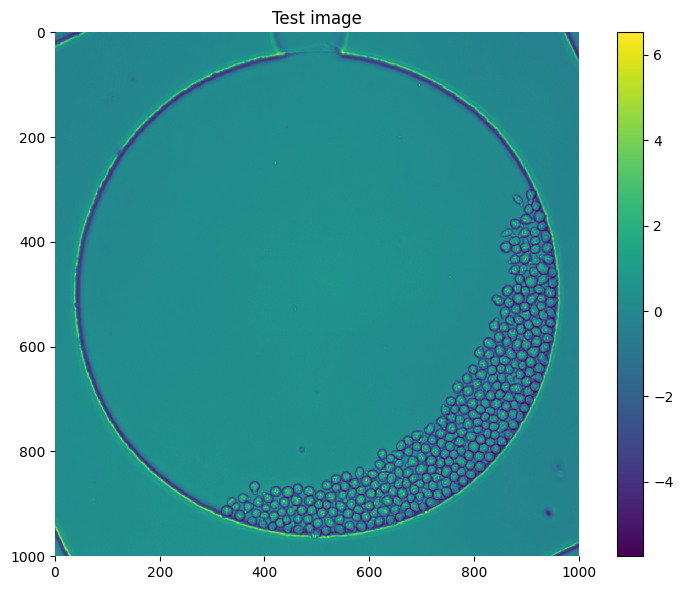

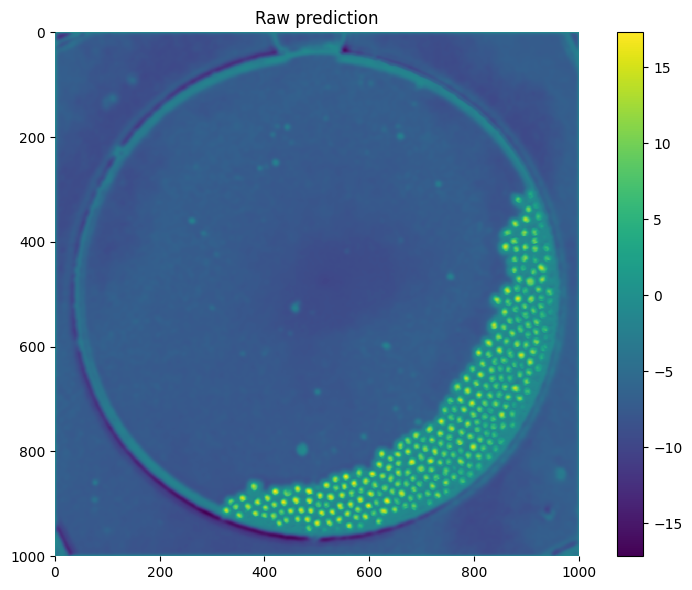

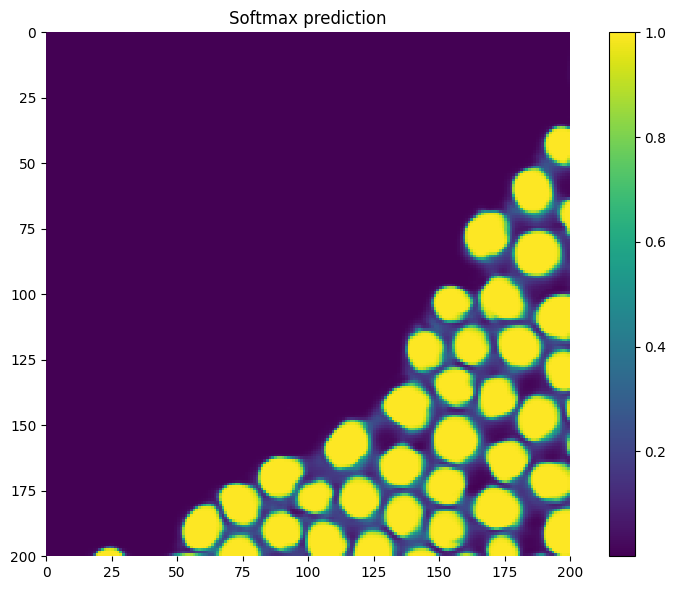

In [16]:
import numpy as np

res_np = res.cpu().detach().numpy()
res_softmax = nn.functional.softmax(res, dim=1).cpu().detach().numpy()


ishow(np.squeeze(im[1].cpu().numpy()), title='Test image')
ishow(res_np[1, 1, :, :], title='Raw prediction')
ishow(res_softmax[1, 1, 600:800, 600:800], title='Softmax prediction')

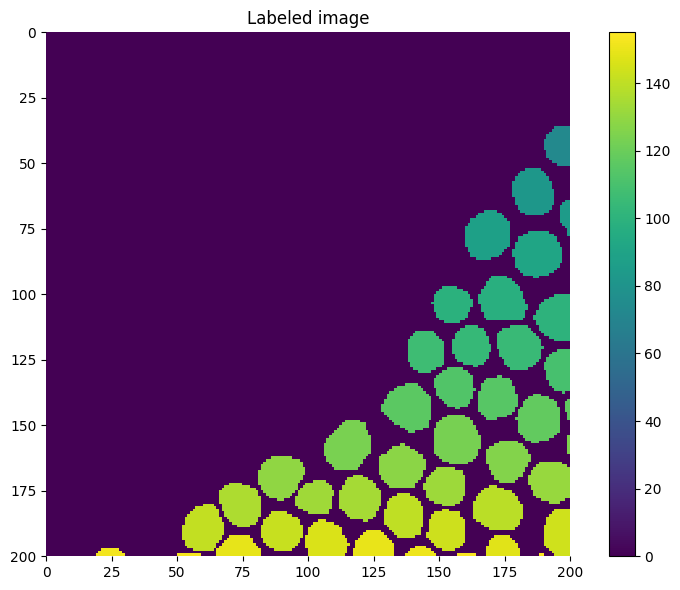

In [17]:
from dl_tools import get_labels


labels = get_labels(res_np[1, 1, :, :])

ishow(labels[600:800, 600:800], title='Labeled image')

In [18]:
from dl_tools import save_results

SAVE_RESULTS = False

if SAVE_RESULTS:
    # Convert from NCHW to NHWC format for save_results function
    res_formatted = np.transpose(res, (0, 2, 3, 1))
    save_results(res_formatted, store_dir = 'results', img_dir = 'BF-C2DL-HSC/test')